In this Notebook, we go through some differential equation examples and how to solve them using neural networks

# First order ODE:

First Order ODE is defined in the form as:
\begin{equation}
    \frac{dy}{dx} + p(x)\cdot y = f(x)
\end{equation}

Where $x$ is defined between $0$ and $1$
\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

And the boundary conidtion at 0:
\begin{equation}
    y(0) = A
\end{equation}

where $A$ is constant

# Solving ODE:

Finding the solution for the differential equation is the same as minimizing loss function ($min\{\mathcal{L} \}$), where the loss function is defined as:

\begin{equation}
    \mathcal{L} = \int_0^1 \left(\frac{d y}{dx} - f(x)\right)^2 dx
\end{equation}

# Neural Networks

\begin{equation}
    y \approx \mathcal{N}(x)
\end{equation}

Loss function:

\begin{equation}   
    MSE = MSE_f + MSE_u
\end{equation}

where the loss of the function is

\begin{equation}
    MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} (\frac{d \mathcal{N}(x)}{dx}|_{x = x_i} - f(x_i))^2
\end{equation}

and the loss of the boundary conditions

\begin{equation}
    MSE_u = \frac{1}{N_u} \sum_{i=1}^{N_u} (\mathcal{N}(x_i) - y(x_i))^2
\end{equation}


## Building Neural Network 

In [1]:
import torch
import torch.nn as nn
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        layer_out = torch.sigmoid(self.hidden_layer(x))
        output = self.output_layer(layer_out)
        return output

In [2]:
model = ANN()
model

ANN(
  (hidden_layer): Linear(in_features=1, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

## Example Function and BC

\begin{equation}
    \begin{cases}
      f(x) = e^x\\
      p(x) = 0
    \end{cases}\,.
\end{equation}

\begin{equation}
    y(0) = 1
\end{equation}


### Exact Solution

\begin{equation}
    y = e^x
\end{equation}

In [90]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x):
    return torch.exp(x)

def f(x):
    return torch.exp(x)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    MSEf = torch.mean((dy_dx - f(x))**2)  #MSEf as defined above
    bc = (y[0, 0] - 1.)**2 #MSEu as defined above
    return MSEf + bc

# build random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)

print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  5.383354187011719
Epoch 2 , Loss:  0.0008246344514191151
Epoch 3 , Loss:  7.337223905778956e-06
Epoch 4 , Loss:  3.599809019760869e-07
Epoch 5 , Loss:  3.599809019760869e-07
Epoch 6 , Loss:  3.599809019760869e-07
Epoch 7 , Loss:  3.599809019760869e-07
Epoch 8 , Loss:  3.599809019760869e-07
Epoch 9 , Loss:  3.599809019760869e-07
Epoch 10 , Loss:  3.599809019760869e-07
Final Loss:  3.599809019760869e-07


In [98]:
#forward Euler
import numpy as np
Nt = 100
T = 1
t = np.linspace(0, 1, Nt)
dt = T/(Nt - 1)
yeuler = np.zeros(Nt)
yeuler[0] = 1

for i in range(1, Nt):
    yeuler[i] = yeuler[i-1] + dt*(np.exp([t[i]]))

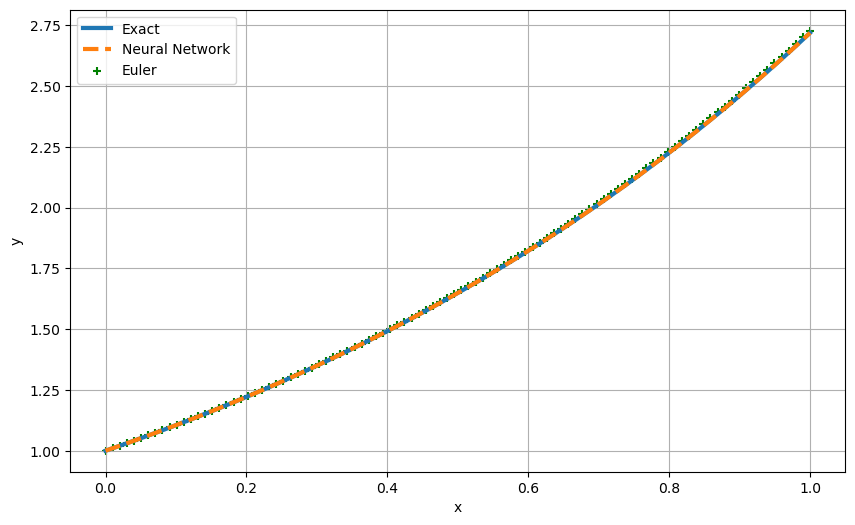

In [99]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
plt.scatter(xtest, yeuler, color = 'green', marker = '+', label = 'Euler')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling1.pdf", bbox_inches='tight')
plt.show()

In [100]:
MSE_euler = (np.abs(yeuler - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MSE between Euler and exact: ", MSE_euler)
print("MSE between NN and exact: ", MSE_NN.detach().numpy())

MSE between Euler and exact:  0.5708307941475441
MSE between NN and exact:  4.302502e-05


=========================================================================================================================================================
=========================================================================================================================================================

## Second Order ODE

$y′′(x) + y(x) = 0$ with $0 ⩽ x ⩽ 8$

$y(0) = 1$
$y′(0) = 0$

The analytical solution is 
$y(x) = cos(x)$

In [313]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())


def f(x):
    return 


def exact_func(x):
    return torch.cos(x)


def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]

    MSEf = torch.mean((y_double_prime + y)**2) #MSEf
    bc1 = (y[0, 0] - 1.)**2 #MSEu1
    bc2 = (dy_dx[0, 0] - 0.)**2 #MSEu2
    return  MSEf + bc1 + bc2


# Build some random data points
x = torch.linspace(0, 8, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 20
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  0.7973067760467529
Epoch 2 , Loss:  0.13858672976493835
Epoch 3 , Loss:  0.044740576297044754
Epoch 4 , Loss:  0.03814254701137543
Epoch 5 , Loss:  0.03680092841386795
Epoch 6 , Loss:  0.03604846075177193
Epoch 7 , Loss:  0.03457856923341751
Epoch 8 , Loss:  0.022904496639966965
Epoch 9 , Loss:  0.010230339132249355
Epoch 10 , Loss:  0.0040913959965109825
Epoch 11 , Loss:  0.003081453498452902
Epoch 12 , Loss:  0.003083149902522564
Epoch 13 , Loss:  0.001599570969119668
Epoch 14 , Loss:  0.0008942083804868162
Epoch 15 , Loss:  0.0005600580479949713
Epoch 16 , Loss:  0.0004778601578436792
Epoch 17 , Loss:  0.00022329184866975993
Epoch 18 , Loss:  0.00011777212785091251
Epoch 19 , Loss:  8.721199264982715e-05
Epoch 20 , Loss:  9.202491492033005e-05
Final Loss:  5.1803326641675085e-05


### Using Runge-Kutta

let us break the main equation into two:

$z1 = y$
$z2 = y^´$

And 

\begin{equation}
  y"(x) + y(x) = 0\\
  y(0) = 1\\
  y´(0) = 0
\end{equation}

So, 

\begin{equation}
  z_2^´ = -z_1\\
  z_1 = 1\\
  z_2 = 0
\end{equation}

In [328]:
from scipy.integrate import solve_ivp

dt = 0.08
x = np.arange(0, 8, dt)

z1 = np.zeros_like(x)
z2 = np.zeros_like(x)

# initial conditions
z1[0] = 1
z2[0] = 0

def mass_spring(x, z): 
    return [z[1], -z[0]]

sol = solve_ivp(mass_spring, [0, 8], [1, 0], method='RK45', t_eval=x)

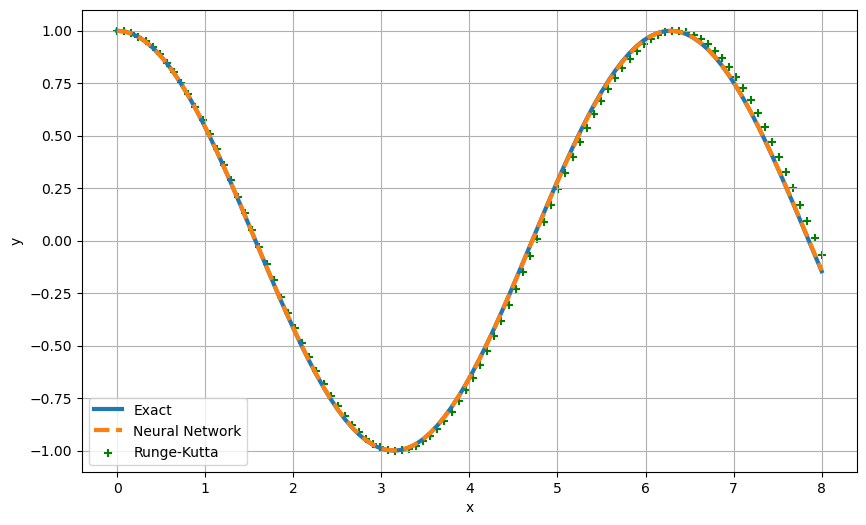

In [329]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 8, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
#plt.scatter(sol.t, sol.y[0,:], color = 'green', marker = '+', markersize=10, label ='Runge-Kutta')
plt.scatter(xtest, sol.y[0,:], color = 'green', marker = '+', label = 'Runge-Kutta')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling2.pdf", bbox_inches='tight')
plt.show()

In [330]:
MSE_RK = (np.abs(sol.y[0,:] - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MSE between Euler and exact: ", MSE_RK)
print("MSE between NN and exact: ", MSE_NN.detach().numpy())

MSE between Euler and exact:  0.7877710834083298
MSE between NN and exact:  0.0013052839


=========================================================================================================================================================
=========================================================================================================================================================

## Second order ODE

\begin{equation}
    \begin{cases}
      y"(x) - y(x) - 3y^2(x) = 0\\
      y(x) = 1\\
      y´(x) = 0
    \end{cases}\,.
\end{equation}

The analystical Solution is 
\begin{equation}
    \begin{cases}
      y(x) = -1/2.sech^2(x/2)
    \end{cases}\,.
\end{equation}

In [173]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())


def f(x):
    return 
import numpy as np

# Build some random data points
x = torch.linspace(-5, 5, 100)[:, None]

def exact_func(x):
    return -0.5*(1/torch.cosh(x/2)**2)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]

    MSEf = torch.mean(((y_double_prime - y - 3.0*(y**2))**2)) #MSEf
    bc1 = (y[int(y.shape[0]/2)-1, 0] + 0.5)**2 #MSEu1
    bc2 = (dy_dx[int(y.shape[0]/2)-1, 0] - 0)**2 #MSEu2
    return  MSEf + bc1 + bc2


def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  0.758597731590271
Epoch 2 , Loss:  0.0014733048155903816
Epoch 3 , Loss:  9.651076652517077e-06
Epoch 4 , Loss:  2.2274157345236745e-06
Epoch 5 , Loss:  2.1425209979497595e-06
Epoch 6 , Loss:  7.306813927243638e-07
Epoch 7 , Loss:  6.830246093159076e-07
Epoch 8 , Loss:  6.830246093159076e-07
Epoch 9 , Loss:  6.830246093159076e-07
Epoch 10 , Loss:  6.830246093159076e-07
Final Loss:  6.830246093159076e-07


### Using Runge-Kutta

let us break the main equation into two:

$z1 = y$
$z2 = y^´$

And 

\begin{equation}
    \begin{cases}
      y"(x) - y(x) - 3y^2(x) = 0\\
      y(x) = -1/2\\
      y´(x) = 0
    \end{cases}\,.
\end{equation}

So, 

\begin{equation}
  z_2^´ - z_1 - 3z_1^2 = 0\\
  z_1 = -1/2\\
  z_2 = 0
\end{equation}

Therefore,

\begin{equation}
  z_2^´ =  z_1 + 3z_1^2(x)\\
  z_1 = -1/2\\
  z_2 = 0
\end{equation}

In [237]:
from scipy.integrate import solve_ivp

dt = 0.1
x = np.arange(0, 5, dt)

z1 = np.zeros_like(x)
z2 = np.zeros_like(x)

# initial conditions
z1[0] = -1/2
z2[0] = 0

def func(x, z): 
    return [z[1], z[0] + 3*z[0]**2]

dt = -0.1
x_ = np.arange(0, -5, dt)

#we solve this ivp twice as the initial valeus is 0 in the middle
sol1 = solve_ivp(func, [0, 5], [-1/2, 0], method='RK45', t_eval=x)
sol2 = solve_ivp(func, [0, -5], [-1/2, 0], method='RK45', t_eval=x_)

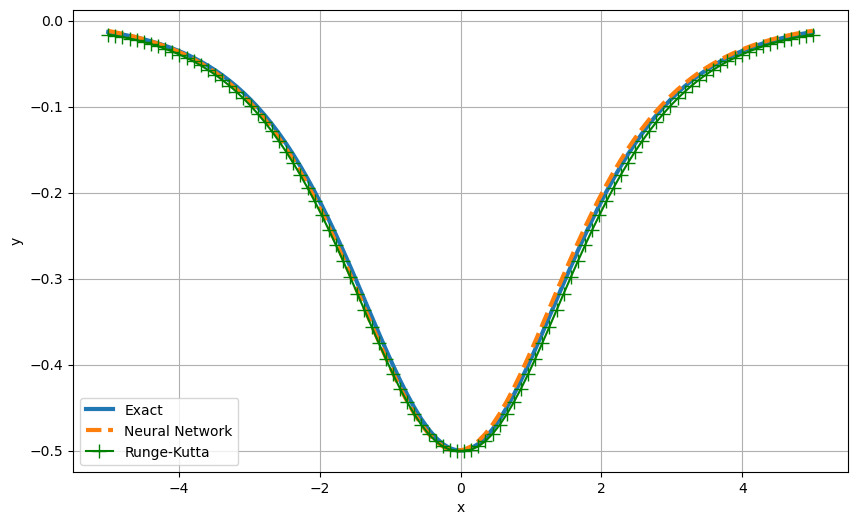

In [245]:
import matplotlib.pyplot as plt

xtest = torch.linspace(-5, 5, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
yrk = np.concatenate((np.flip(sol2.y[0,:]), sol1.y[0,:]))
plt.plot(xtest, yrk, color = 'green', marker = '+', markersize=10, label = 'Runge-Kutta')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling3.pdf", bbox_inches='tight')
plt.show()

In [247]:
MSE_RK = (np.abs(yrk - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MAE between Runge-Kutta and exact: ", MSE_RK)
print("MAE between NN and exact: ", MSE_NN.detach().numpy())

MAE between Runge-Kutta and exact:  0.18670417442719708
MAE between NN and exact:  0.004819171


=========================================================================================================================================================
=========================================================================================================================================================

## Exponnetial Decay

An exponential decay of a quantity $g(x)$ is described by the equation

$$
 g'(x) = -\gamma g(x)
$$


with $g(0) = g_0$ for some chosen initial value $g_0$.

The exact solution of exponential growth equation is

$$
g(x) = g_0 \exp\left(-\gamma x\right)
$$


Where (example) $\gamma = 2$ and $g0 = 10$ (This can change)

We can notice that BC1 is $g(0) = g_0$

We can build two losses here: first loss is MSEf is the loss of the quation 

$$
g'(x) = -\gamma g(x)
$$

Where we minimize the differnece between the two terms

and the second loss is the boundary condition loss where  

$$
g(0) = g_0
$$


In [303]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x, g0=10, gamma=2):
    return g0*torch.exp(-gamma*x)

def loss(model, x):
    g0 = 10
    gamma = 2
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx + gamma * y)**2) #MSEf
    bc1 = (y[0, 0] - g0)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  98.16954040527344
Epoch 2 , Loss:  0.2585567235946655
Epoch 3 , Loss:  7.030773849692196e-05
Epoch 4 , Loss:  1.7937371012521908e-05
Epoch 5 , Loss:  4.54696510132635e-06
Epoch 6 , Loss:  1.3120920812070835e-06
Epoch 7 , Loss:  2.010195021284744e-05
Epoch 8 , Loss:  7.499383514186775e-07
Epoch 9 , Loss:  5.120983814776991e-07
Epoch 10 , Loss:  1.9125118910778838e-07
Final Loss:  1.6336696262442274e-07


In [304]:
#forward Euler

#linespace
Nt = 100
T = 1
t = np.linspace(0, 1, Nt)
dt = T/(Nt - 1)
alpha = 2

#init values for eurler
yeuler = np.zeros(Nt)

#initial condition
g0 = 10
yeuler[0] = g0

for i in range(1, Nt):
    yeuler[i] = yeuler[i-1] - dt*(alpha*yeuler[i-1])

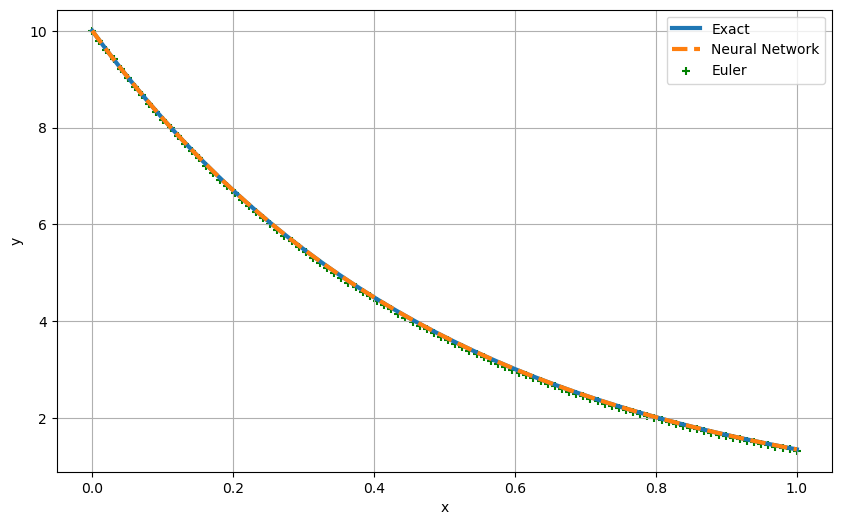

In [305]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
#plt.plot(xtest, yeuler , "--" , label="Euler", linewidth=3.0)
plt.scatter(xtest, yeuler, color = 'green', marker = '+', label = 'Euler')
#plt.plot(xtest, yeuler, color = 'green', marker = '+', markersize=10, label = 'Euler')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling5.pdf", bbox_inches='tight')
plt.show()

In [306]:
MSE_euler = (np.abs(yeuler - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MAE between Euler and exact: ", MSE_euler)
print("MAE between NN and exact: ", MSE_NN.detach().numpy())

MAE between Euler and exact:  2.742137388293165
MAE between NN and exact:  2.3170709e-05


=========================================================================================================================================================
=========================================================================================================================================================

## Population Growth

$$
g'(t) = \alpha g(t)(A - g(t))
$$

where $g(0) = g_0$.

In this example, we let $\alpha = 2$, $A = 1$, and $g_0 = 1.2$.

Exact solution is given as:

$$
g'(t) = Ag_0/(g_0+ (A-g_0)\exp(-\alpha A x)
$$

In [307]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

# Those can be changed
g0 = 1.2
alpha = 2
A = 1

def exact_func(x):
    alpha, A, g0 = 2, 1, 1.2 
    return A*g0/(g0 + (A - g0)*torch.exp(-alpha*A*x))

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx - (alpha * y * (A - y)))**2) #MSEf
    bc1 = (y[0, 0] - g0)**2 #MSEu1
    return  MSEf + bc1

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  4.290450096130371
Epoch 2 , Loss:  0.011941088363528252
Epoch 3 , Loss:  0.0007325549959205091
Epoch 4 , Loss:  0.00047481476212851703
Epoch 5 , Loss:  4.649959009839222e-05
Epoch 6 , Loss:  4.592930508806603e-06
Epoch 7 , Loss:  6.982976969993615e-07
Epoch 8 , Loss:  6.982976969993615e-07
Epoch 9 , Loss:  6.982976969993615e-07
Epoch 10 , Loss:  6.982976969993615e-07
Final Loss:  6.982976969993615e-07


In [308]:
#forward Euler
import numpy as np
Nt = 100
g0 = 1.2
T = 1
t = np.linspace(0, 1, Nt)
dt = T/(Nt - 1)
alpha = 2
yeuler = np.zeros(Nt)
yeuler[0] = g0


for i in range(1,Nt):
    yeuler[i] = yeuler[i-1] + dt*(alpha * yeuler[i-1]*(A - yeuler[i-1]))

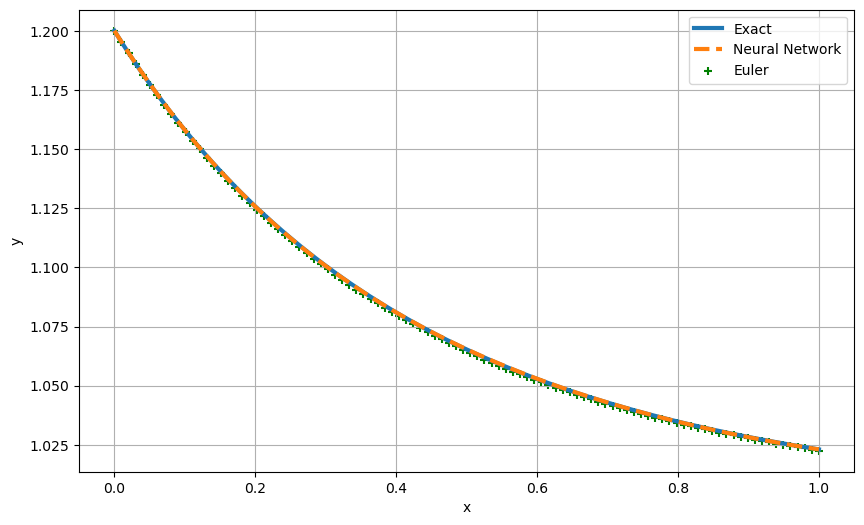

In [309]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
plt.scatter(xtest, yeuler, color = 'green', marker = '+', label = 'Euler')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling6.pdf", bbox_inches='tight')
plt.show()

In [310]:
MSE_euler = (np.abs(yeuler - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MAE between Euler and exact: ", MSE_euler)
print("MAE between NN and exact: ", MSE_NN.detach().numpy())

MAE between Euler and exact:  0.05436935615183473
MAE between NN and exact:  5.6945086e-05


=========================================================================================================================================================
=========================================================================================================================================================

## Poisson equation

$$
  -g''(x) = f(x)
$$


BC1 

$$
g(0) = 0
$$

BC2

$$
g(1) = 0
$$

In [296]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

# Those can be changed
g0 = 1.2
alpha = 2
A = 1

def exact_func(x):
    return x*(1-x)*torch.exp(x)

def f(x):
    return (3*x + x**2)*torch.exp(x)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((y_double_prime + f(x))**2) #MSEf
    bc1 = (y[0, 0] - 0)**2 #MSEu1
    bc2 = (y[-1, 0] - 0)**2 #MSEu2
    return  MSEf + bc1 + bc2

# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 9
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  23.464902877807617
Epoch 2 , Loss:  5.045087814331055
Epoch 3 , Loss:  0.0351070873439312
Epoch 4 , Loss:  0.003426559502258897
Epoch 5 , Loss:  0.0016819657757878304
Epoch 6 , Loss:  0.0002204968041041866
Epoch 7 , Loss:  9.398035035701469e-05
Epoch 8 , Loss:  4.3011004891013727e-05
Epoch 9 , Loss:  2.903003951360006e-05
Final Loss:  2.2418527805712074e-05


In [297]:
def f(x):
    return (3*x + x**2)*np.exp(x)

Nx = 100
x = np.linspace(0,1, Nx)
dx = 1/(Nx - 1)


# start the matrix A
A = np.zeros((Nx-2,Nx-2))

A[0,0] = 2
A[0,1] = -1

for i in range(1,Nx-3):
    A[i,i-1] = -1
    A[i,i] = 2
    A[i,i+1] = -1

A[Nx - 3, Nx - 4] = -1
A[Nx - 3, Nx - 3] = 2

# Set up the vector f
f_vec = dx**2 * f(x[1:-1])

# Solve the equation
g_res = np.linalg.solve(A,f_vec)

g_vec = np.zeros(Nx)
g_vec[1:-1] = g_res

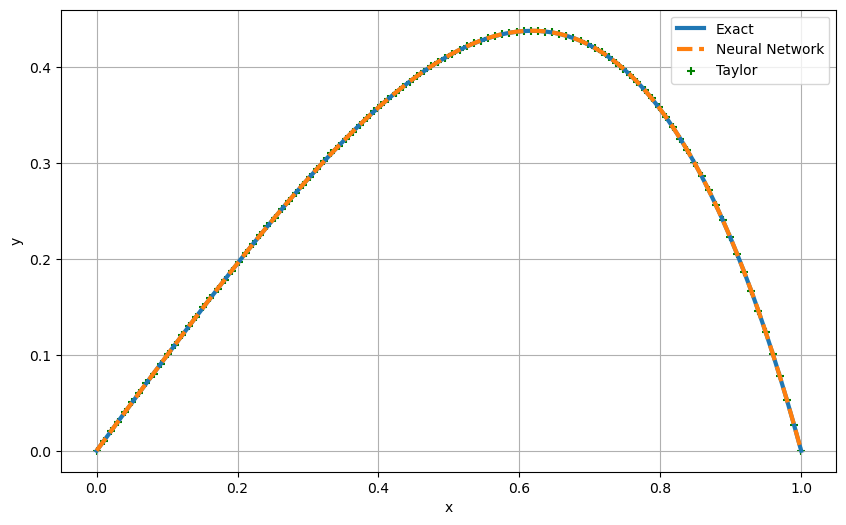

In [301]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
plt.scatter(xtest, g_vec, color = 'green', marker = '+', label = 'Taylor')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling7.pdf", bbox_inches='tight')
plt.show()

In [302]:
MSE_taylor = (np.abs(g_vec - exact_func(xtest).detach().numpy())).mean()
MSE_NN = (np.abs(ypred - exact_func(xtest).detach().numpy())).mean()
print("MAE between Taylor and exact: ", MSE_taylor)
print("MAE between NN and exact: ", MSE_NN.detach().numpy())

MAE between Taylor and exact:  0.15354373122106404
MAE between NN and exact:  7.311999e-05


=========================================================================================================================================================
=========================================================================================================================================================

## Sample ODE
$$
y =−2xy
$$

Exact solution is 

$$
y(x)=exp−x^2
$$

and BC1 

$$
y(0) = 1
$$

In [272]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())

def exact_func(x):
    return torch.exp(-x**2)

def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((dy_dx + 2*x*y)**2) #MSEf
    bc1 = (y[0, 0] - 1)**2 #MSEu1
    #bc2 = (y[-1, 0] - 1)**2 #MSEu1
    return  MSEf + bc1


# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]
def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  0.7211085557937622
Epoch 2 , Loss:  0.03313169255852699
Epoch 3 , Loss:  0.007737157866358757
Epoch 4 , Loss:  1.3337282325665e-05
Epoch 5 , Loss:  2.1192399799474515e-06
Epoch 6 , Loss:  2.5830502181634074e-07
Epoch 7 , Loss:  2.5830502181634074e-07
Epoch 8 , Loss:  2.5830502181634074e-07
Epoch 9 , Loss:  2.5830502181634074e-07
Epoch 10 , Loss:  2.5830502181634074e-07
Final Loss:  2.5830502181634074e-07


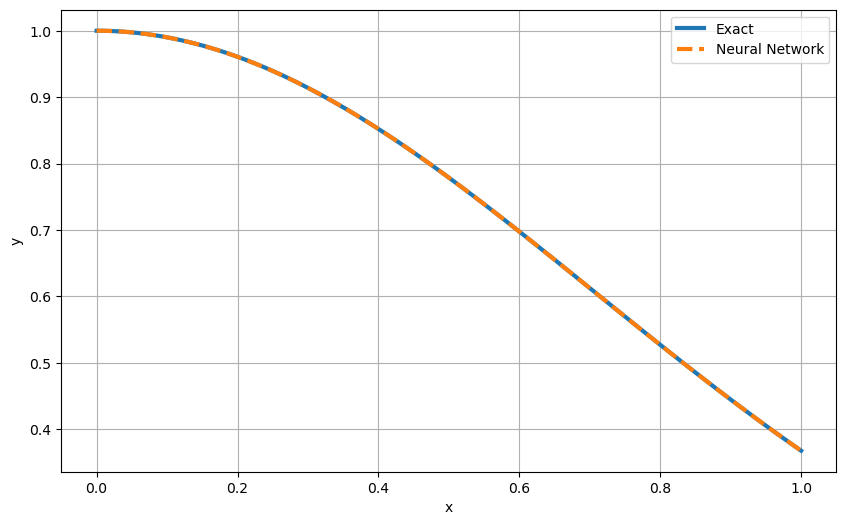

In [295]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling8.pdf", bbox_inches='tight')
plt.show()

=========================================================================================================================================================
=========================================================================================================================================================

## Another example of second Order ODE


\begin{equation}
    \frac{d^2 y}{dx^2} + p(x) \frac{dy}{dx} + q(x) y = f(x)
\end{equation}

\begin{equation}
    x \; \in \; [0, 1]
\end{equation}

\begin{equation}
    y(0) = A
\end{equation}

\begin{equation}
    y(1) = B
\end{equation}

## Example Function and BC

\begin{equation}
    \begin{cases}
      p(x) = 0\\
      q(x) = 0\\
      f(x) = -1
    \end{cases}\,.
\end{equation}

\begin{equation}
    \begin{cases}
      y(0) = 0\\
      y(1) = 0
    \end{cases}\,.
\end{equation}

### Exact Solution

\begin{equation}
    y(x) = - \frac{1}{2}x^2 + \frac{1}{2}x
\end{equation}


In [333]:
model = ANN()
optimizer = torch.optim.LBFGS(model.parameters())


def f(x):
    return -torch.ones(x.shape[0], x.shape[1])


def exact_func(x):
    return -0.5*torch.pow(x, 2) + 0.5*x


def loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]
    
    MSEf = torch.mean((y_double_prime - f(x))**2) #MSEf
    bc1 = 0.5*(y[0, 0] - 0.)**2 #MSEu1
    bc2 = 0.5*(y[-1, 0] - 0.)**2 #MSEu2
    return  MSEf + bc1 + bc2


# Build some random data points
x = torch.linspace(0, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(model, x)
    l.backward()
    return l

epochs = 10
for i in range(epochs):
    print("Epoch", str(i+1),", Loss: ",  loss(model, x).item())
    optimizer.step(closure)
    
print("Final Loss: ", loss(model, x).item())

Epoch 1 , Loss:  1.1478919982910156
Epoch 2 , Loss:  0.005451496224850416
Epoch 3 , Loss:  7.404848929581931e-06
Epoch 4 , Loss:  9.55617792897101e-07
Epoch 5 , Loss:  9.55617792897101e-07
Epoch 6 , Loss:  9.55617792897101e-07
Epoch 7 , Loss:  9.55617792897101e-07
Epoch 8 , Loss:  9.55617792897101e-07
Epoch 9 , Loss:  9.55617792897101e-07
Epoch 10 , Loss:  9.55617792897101e-07
Final Loss:  9.55617792897101e-07


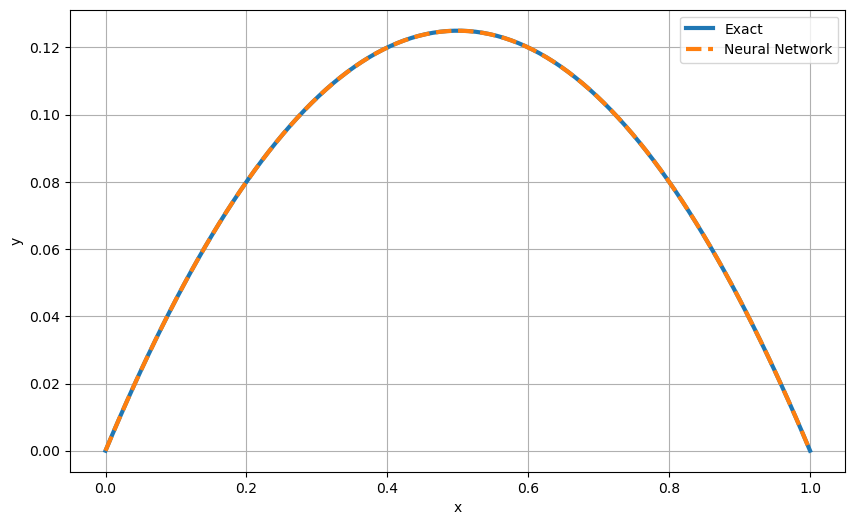

In [334]:
import matplotlib.pyplot as plt

xtest = torch.linspace(0, 1, 100)[:, None]
with torch.no_grad():
    ypred = model(xtest)

plt.figure(figsize=(10, 6))
plt.plot(xtest, exact_func(xtest), label="Exact", linewidth=3.0)
plt.plot(xtest, ypred, "--" ,label="Neural Network" , linewidth=3.0)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.savefig("report_modeling4.pdf", bbox_inches='tight')
plt.show()

## References:

https://sevent-christina.medium.com/deep-learning-solves-differential-equations-better-than-any-other-numerical-method-14126c7a2a7c

https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter11.html

https://arxiv.org/pdf/2307.11237

https://www.sciencedirect.com/science/article/pii/S0021999118307125